# Импорт библиотек

In [4]:
#импорт требуемых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, ridge_regression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, IsolationForest, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout

import pickle

%matplotlib inline
print(tf.__version__)

2.8.2


# Загрузка датасета

Монтирование диска google

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Чтение файла X_bp.xlsx Что странно в исходныйх файлах - точность призков.... посмотрим:

In [6]:
#Чтение файла X_bp.xlsx
pd.set_option('display.float_format', lambda x: '%4.15f' % x)
X_bp=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/ВКР/X_bp.xlsx',header=0,dtype={0: np.int32})
X_bp.head()

,Unnamed: 0,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2"
0,0,1.857142857142850,2030.000000000000000,738.736842105263008,30.000000000000000,22.267857142857100,100.000000000000000,210.000000000000000,70.000000000000000,3000.000000000000000,220.000000000000000
1,1,1.857142857142850,2030.000000000000000,738.736842105263008,50.000000000000000,23.750000000000000,284.615384615384016,210.000000000000000,70.000000000000000,3000.000000000000000,220.000000000000000
2,2,1.857142857142850,2030.000000000000000,738.736842105263008,49.899999999999999,33.000000000000000,284.615384615384016,210.000000000000000,70.000000000000000,3000.000000000000000,220.000000000000000
3,3,1.857142857142850,2030.000000000000000,738.736842105263008,129.000000000000000,21.250000000000000,300.000000000000000,210.000000000000000,70.000000000000000,3000.000000000000000,220.000000000000000
4,4,2.771331058020470,2030.000000000000000,753.000000000000000,111.859999999999999,22.267857142857100,284.615384615384016,210.000000000000000,70.000000000000000,3000.000000000000000,220.000000000000000


Отключаем отображение большого количество знаков после запятой для типа float - для удобства

In [7]:
pd.set_option('display.float_format', lambda x: '%4.4f' % x)

Выведем инфо по датафрейму

In [8]:
print(X_bp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0                            1023 non-null   int32  
 1   Соотношение матрица-наполнитель       1023 non-null   float64
 2   Плотность, кг/м3                      1023 non-null   float64
 3   модуль упругости, ГПа                 1023 non-null   float64
 4   Количество отвердителя, м.%           1023 non-null   float64
 5   Содержание эпоксидных групп,%_2       1023 non-null   float64
 6   Температура вспышки, С_2              1023 non-null   float64
 7   Поверхностная плотность, г/м2         1023 non-null   float64
 8   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 9   Прочность при растяжении, МПа         1023 non-null   float64
 10  Потребление смолы, г/м2               1023 non-null   float64
dtypes: float64(10), i

Чтение файла X_nup.xlsx. Так же замечаем странность - точность параметров Шаг нашивки и Плотность нашивки крайне высока... Для Угла нашивки есть толькот два целых значения

In [9]:
#Чтение файла X_nup.xlsx
X_nup=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/ВКР/X_nup.xlsx',header=0,dtype={0: np.int32, 1: np.int32})
X_nup.head()

,Unnamed: 0,"Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,0,0,4.0000,57.0000
1,1,0,4.0000,60.0000
2,2,0,4.0000,70.0000
3,3,0,5.0000,47.0000
4,4,0,5.0000,57.0000


In [10]:
print(X_nup.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1040 non-null   int32  
 1   Угол нашивки, град  1040 non-null   int32  
 2   Шаг нашивки         1040 non-null   float64
 3   Плотность нашивки   1040 non-null   float64
dtypes: float64(2), int32(2)
memory usage: 24.5 KB
None


Соединяем данные в один датафрейм.  В исходных тпблицах количество строк не совпадает, соответвтенно при объединении по inner по индексу сразу отсеиваются пропуски в одной из таблиц.

In [14]:
#Соединяем данные двух датафреймов. 
Dfx = pd.merge(X_bp, X_nup, on='Unnamed: 0', how='inner')
Df = Dfx.drop(['Unnamed: 0'], axis=1)
Df.head()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,1.8571,2030.0000,738.7368,30.0000,22.2679,100.0000,210.0000,70.0000,3000.0000,220.0000,0,4.0000,57.0000
1,1.8571,2030.0000,738.7368,50.0000,23.7500,284.6154,210.0000,70.0000,3000.0000,220.0000,0,4.0000,60.0000
2,1.8571,2030.0000,738.7368,49.9000,33.0000,284.6154,210.0000,70.0000,3000.0000,220.0000,0,4.0000,70.0000
3,1.8571,2030.0000,738.7368,129.0000,21.2500,300.0000,210.0000,70.0000,3000.0000,220.0000,0,5.0000,47.0000
4,2.7713,2030.0000,753.0000,111.8600,22.2679,284.6154,210.0000,70.0000,3000.0000,220.0000,0,5.0000,57.0000


In [12]:
#выведем сведений об итоговом датафрейме
print(Df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023 entries, 0 to 1022
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1023 non-null   float64
 1   Плотность, кг/м3                      1023 non-null   float64
 2   модуль упругости, ГПа                 1023 non-null   float64
 3   Количество отвердителя, м.%           1023 non-null   float64
 4   Содержание эпоксидных групп,%_2       1023 non-null   float64
 5   Температура вспышки, С_2              1023 non-null   float64
 6   Поверхностная плотность, г/м2         1023 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 8   Прочность при растяжении, МПа         1023 non-null   float64
 9   Потребление смолы, г/м2               1023 non-null   float64
 10  Угол нашивки, град                    1023 non-null   int32  
 11  Шаг нашивки      

# Разведочный анализ

In [10]:
#проверим пропуски
for p in Df.columns:
  sum_isna=Df[p].isna().sum()
  if sum_isna>0:
    print("!!!  Количество пропусков в столбце " + p + "=" + str(sum_isna))
  else:
    print("     Пропуски отсутствуют в столбце " + p) 

     Пропуски отсутствуют в столбце Соотношение матрица-наполнитель
     Пропуски отсутствуют в столбце Плотность, кг/м3
     Пропуски отсутствуют в столбце модуль упругости, ГПа
     Пропуски отсутствуют в столбце Количество отвердителя, м.%
     Пропуски отсутствуют в столбце Содержание эпоксидных групп,%_2
     Пропуски отсутствуют в столбце Температура вспышки, С_2
     Пропуски отсутствуют в столбце Поверхностная плотность, г/м2
     Пропуски отсутствуют в столбце Модуль упругости при растяжении, ГПа
     Пропуски отсутствуют в столбце Прочность при растяжении, МПа
     Пропуски отсутствуют в столбце Потребление смолы, г/м2
     Пропуски отсутствуют в столбце Угол нашивки, град
     Пропуски отсутствуют в столбце Шаг нашивки
     Пропуски отсутствуют в столбце Плотность нашивки


Пропуски отсутствуют. Количество заполненных значений по каждому параметру соответствует общему количеству строк первого файла. В исходных тпблицах количество строк не совпадает, соответвтенно при объединении по inner по индексу сразу отсеиваются пропуски в одной из таблиц.

In [11]:
# выведем среднее значение по колонкам
np.mean(Df)

Соотношение матрица-наполнитель           2.9304
Плотность, кг/м3                       1975.7349
модуль упругости, ГПа                   739.9232
Количество отвердителя, м.%             110.5708
Содержание эпоксидных групп,%_2          22.2444
Температура вспышки, С_2                285.8822
Поверхностная плотность, г/м2           482.7318
Модуль упругости при растяжении, ГПа     73.3286
Прочность при растяжении, МПа          2466.9228
Потребление смолы, г/м2                 218.4231
Угол нашивки, град                       44.2522
Шаг нашивки                               6.8992
Плотность нашивки                        57.1539
dtype: float64

In [12]:
# выведем медианное значение каждого столбца
for p in Df.columns:
  median_col = np.median(Df[p]) 
  print(str(p)+" ["+str(median_col)+ "]")

Соотношение матрица-наполнитель [2.90687765033521]
Плотность, кг/м3 [1977.62165679058]
модуль упругости, ГПа [739.664327697792]
Количество отвердителя, м.% [110.564839894065]
Содержание эпоксидных групп,%_2 [22.2307437560244]
Температура вспышки, С_2 [285.896812331237]
Поверхностная плотность, г/м2 [451.86436518306]
Модуль упругости при растяжении, ГПа [73.2688045943481]
Прочность при растяжении, МПа [2459.52452600309]
Потребление смолы, г/м2 [219.198882195134]
Угол нашивки, град [0.0]
Шаг нашивки [6.9161438559491]
Плотность нашивки [57.3419198469929]


Выведем описательную статистику по датафрейму

In [13]:
Df.describe().T

,count,mean,std,min,25%,50%,75%,max
Соотношение матрица-наполнитель,1023.0000,2.9304,0.9132,0.3894,2.3179,2.9069,3.5527,5.5917
"Плотность, кг/м3",1023.0000,1975.7349,73.7292,1731.7646,1924.1555,1977.6217,2021.3744,2207.7735
"модуль упругости, ГПа",1023.0000,739.9232,330.2316,2.4369,500.0475,739.6643,961.8125,1911.5365
"Количество отвердителя, м.%",1023.0000,110.5708,28.2959,17.7403,92.4435,110.5648,129.7304,198.9532
"Содержание эпоксидных групп,%_2",1023.0000,22.2444,2.4063,14.2550,20.6080,22.2307,23.9619,33.0000
"Температура вспышки, С_2",1023.0000,285.8822,40.9433,100.0000,259.0665,285.8968,313.0021,413.2734
"Поверхностная плотность, г/м2",1023.0000,482.7318,281.3147,0.6037,266.8166,451.8644,693.2250,1399.5424
"Модуль упругости при растяжении, ГПа",1023.0000,73.3286,3.1190,64.0541,71.2450,73.2688,75.3566,82.6821
"Прочность при растяжении, МПа",1023.0000,2466.9228,485.6280,1036.8566,2135.8504,2459.5245,2767.1931,3848.4367
"Потребление смолы, г/м2",1023.0000,218.4231,59.7359,33.8030,179.6275,219.1989,257.4817,414.5906


Построим гистограммы распределения и "ящики с усами" для каждого признака

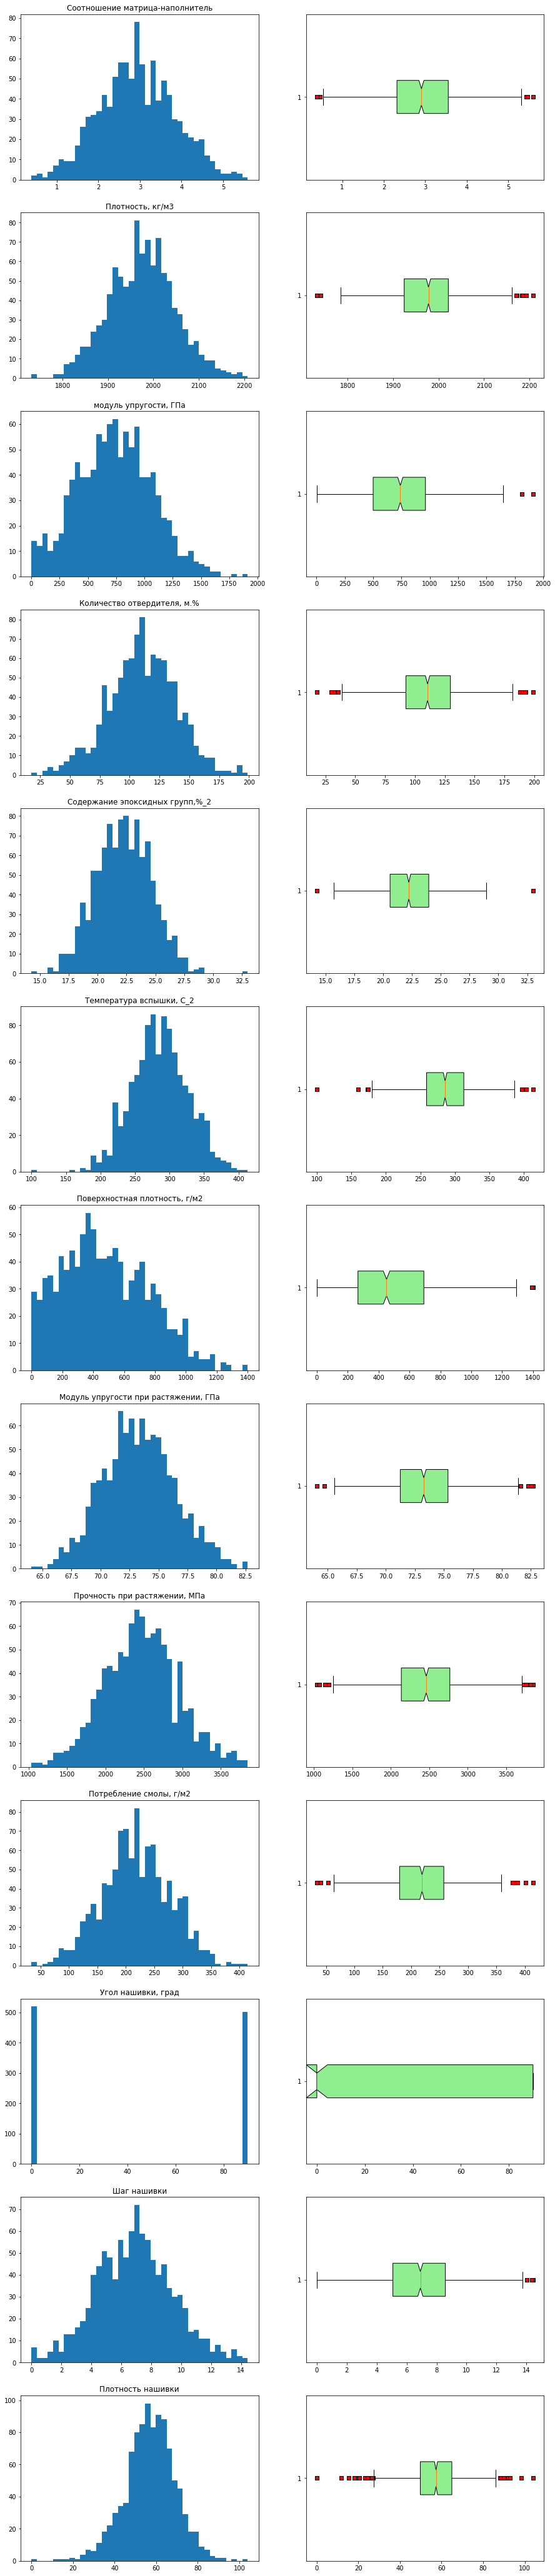

In [14]:
#Гистограммы распределения/ящики с усами
nr = len(Df.columns)
nc = 2
fig = plt.figure(figsize=(15,75))
axes = fig.subplots(nrows=nr, ncols=nc)
c = 0
n = 0 
for p in Df.columns:
    axes[c,n].set(title=p)
    axes[c,n].hist(Df[p], bins=40)
    n += 1
    bp = axes[c,n].boxplot(Df[p], vert=False, flierprops=dict(markerfacecolor='r', marker='s'), widths=0.2, notch=True, patch_artist=True)
    for nB in bp['boxes']:
        nB.set_facecolor('lightgreen')
    n += 1
    if n%nc == 0 :
      c = c + 1
      n = 0
 
plt.show()

Видим, что все параметры, кроме 'Угол нашивки, град', имеют вид нормального распредления. 'Угол нашивки, град' принимает всего лишь два значения

Проверим на наличие дубликатов данных

In [15]:
#Проверим присутствуют ли в датафрейме полные дубли строк?
Df.value_counts()

Соотношение матрица-наполнитель  Плотность, кг/м3  модуль упругости, ГПа  Количество отвердителя, м.%  Содержание эпоксидных групп,%_2  Температура вспышки, С_2  Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  Прочность при растяжении, МПа  Потребление смолы, г/м2  Угол нашивки, град  Шаг нашивки  Плотность нашивки
0.3894                           1917.6999         602.0932               93.3466                      24.9661                          218.3034                  325.2000                       71.6934                               2453.2904                      284.3890                 90                  8.1603       58.0390              1
3.3314                           1996.3462         497.2811               123.9619                     21.9323                          239.2289                  268.8838                       71.2211                               2492.5481                      111.0740                 0                   8.7723      

In [16]:
#Проверим, есть ли одинаковые строки

Df_dedupped = Df.drop_duplicates(['Соотношение матрица-наполнитель', 
                             'Плотность, кг/м3', 
                             'модуль упругости, ГПа', 
                             'Количество отвердителя, м.%', 
                             'Содержание эпоксидных групп,%_2', 
                             'Температура вспышки, С_2', 
                             'Поверхностная плотность, г/м2', 
                             'Модуль упругости при растяжении, ГПа', 
                             'Прочность при растяжении, МПа', 
                             'Потребление смолы, г/м2', 
                             'Угол нашивки, град', 
                             'Шаг нашивки', 
                             'Плотность нашивки'])
print(Df.shape)
print(Df_dedupped.shape)

(1023, 13)
(1023, 13)


 Полные дубли данных отсутствуют!

In [17]:
#Дубликаты данных - проверим, есть ли признаки с высоким количеством одинаковых значений
num_rows = len(Df.index)
xcols = []

for col in Df.columns:
    cnts = Df[col].value_counts(dropna=False)

    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        xcols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

if len(xcols) == 0 :
  print (len(xcols))
  print ('Признаки с высокой долей одного значения отсутствуют')

0
Признаки с высокой долей одного значения отсутствуют


Выведем дисперсию каждого признака

In [18]:
#дисперсия значений
Df.var()

Соотношение матрица-наполнитель             0.8340
Плотность, кг/м3                         5435.9994
модуль упругости, ГПа                  109052.8968
Количество отвердителя, м.%               800.6586
Содержание эпоксидных групп,%_2             5.7903
Температура вспышки, С_2                 1676.3505
Поверхностная плотность, г/м2           79137.9549
Модуль упругости при растяжении, ГПа        9.7281
Прочность при растяжении, МПа          235834.5605
Потребление смолы, г/м2                  3568.3814
Угол нашивки, град                       2026.4217
Шаг нашивки                                 6.5714
Плотность нашивки                         152.5464
dtype: float64

In [19]:
# Сколько же всего одинаковых значений в каждой колонке?
for col in Df.columns:
  notuni_d = Df[col].value_counts()
  print(notuni_d)
  print('')

1.8571    4
3.5323    2
1.5982    2
2.8774    2
2.9197    2
         ..
4.2753    1
2.9088    1
2.6613    1
3.3247    1
3.8080    1
Name: Соотношение матрица-наполнитель, Length: 1014, dtype: int64

2030.0000    6
2000.0000    2
1980.0000    2
1950.0000    2
1880.0000    2
            ..
1888.3491    1
1894.1044    1
2150.7931    1
1948.8786    1
1890.4135    1
Name: Плотность, кг/м3, Length: 1013, dtype: int64

738.7368    4
609.4980    1
593.2646    1
354.7524    1
694.4308    1
           ..
546.8161    1
730.8310    1
923.0845    1
891.7850    1
417.3162    1
Name: модуль упругости, ГПа, Length: 1020, dtype: int64

129.0000    12
111.8600     8
30.0000      1
116.3962     1
137.9838     1
            ..
109.2466     1
62.7433      1
119.9244     1
122.2732     1
129.1834     1
Name: Количество отвердителя, м.%, Length: 1005, dtype: int64

21.2500    12
22.2679     9
25.5766     1
25.0508     1
23.2762     1
           ..
21.1326     1
23.9612     1
21.0435     1
20.6463     1
27.47

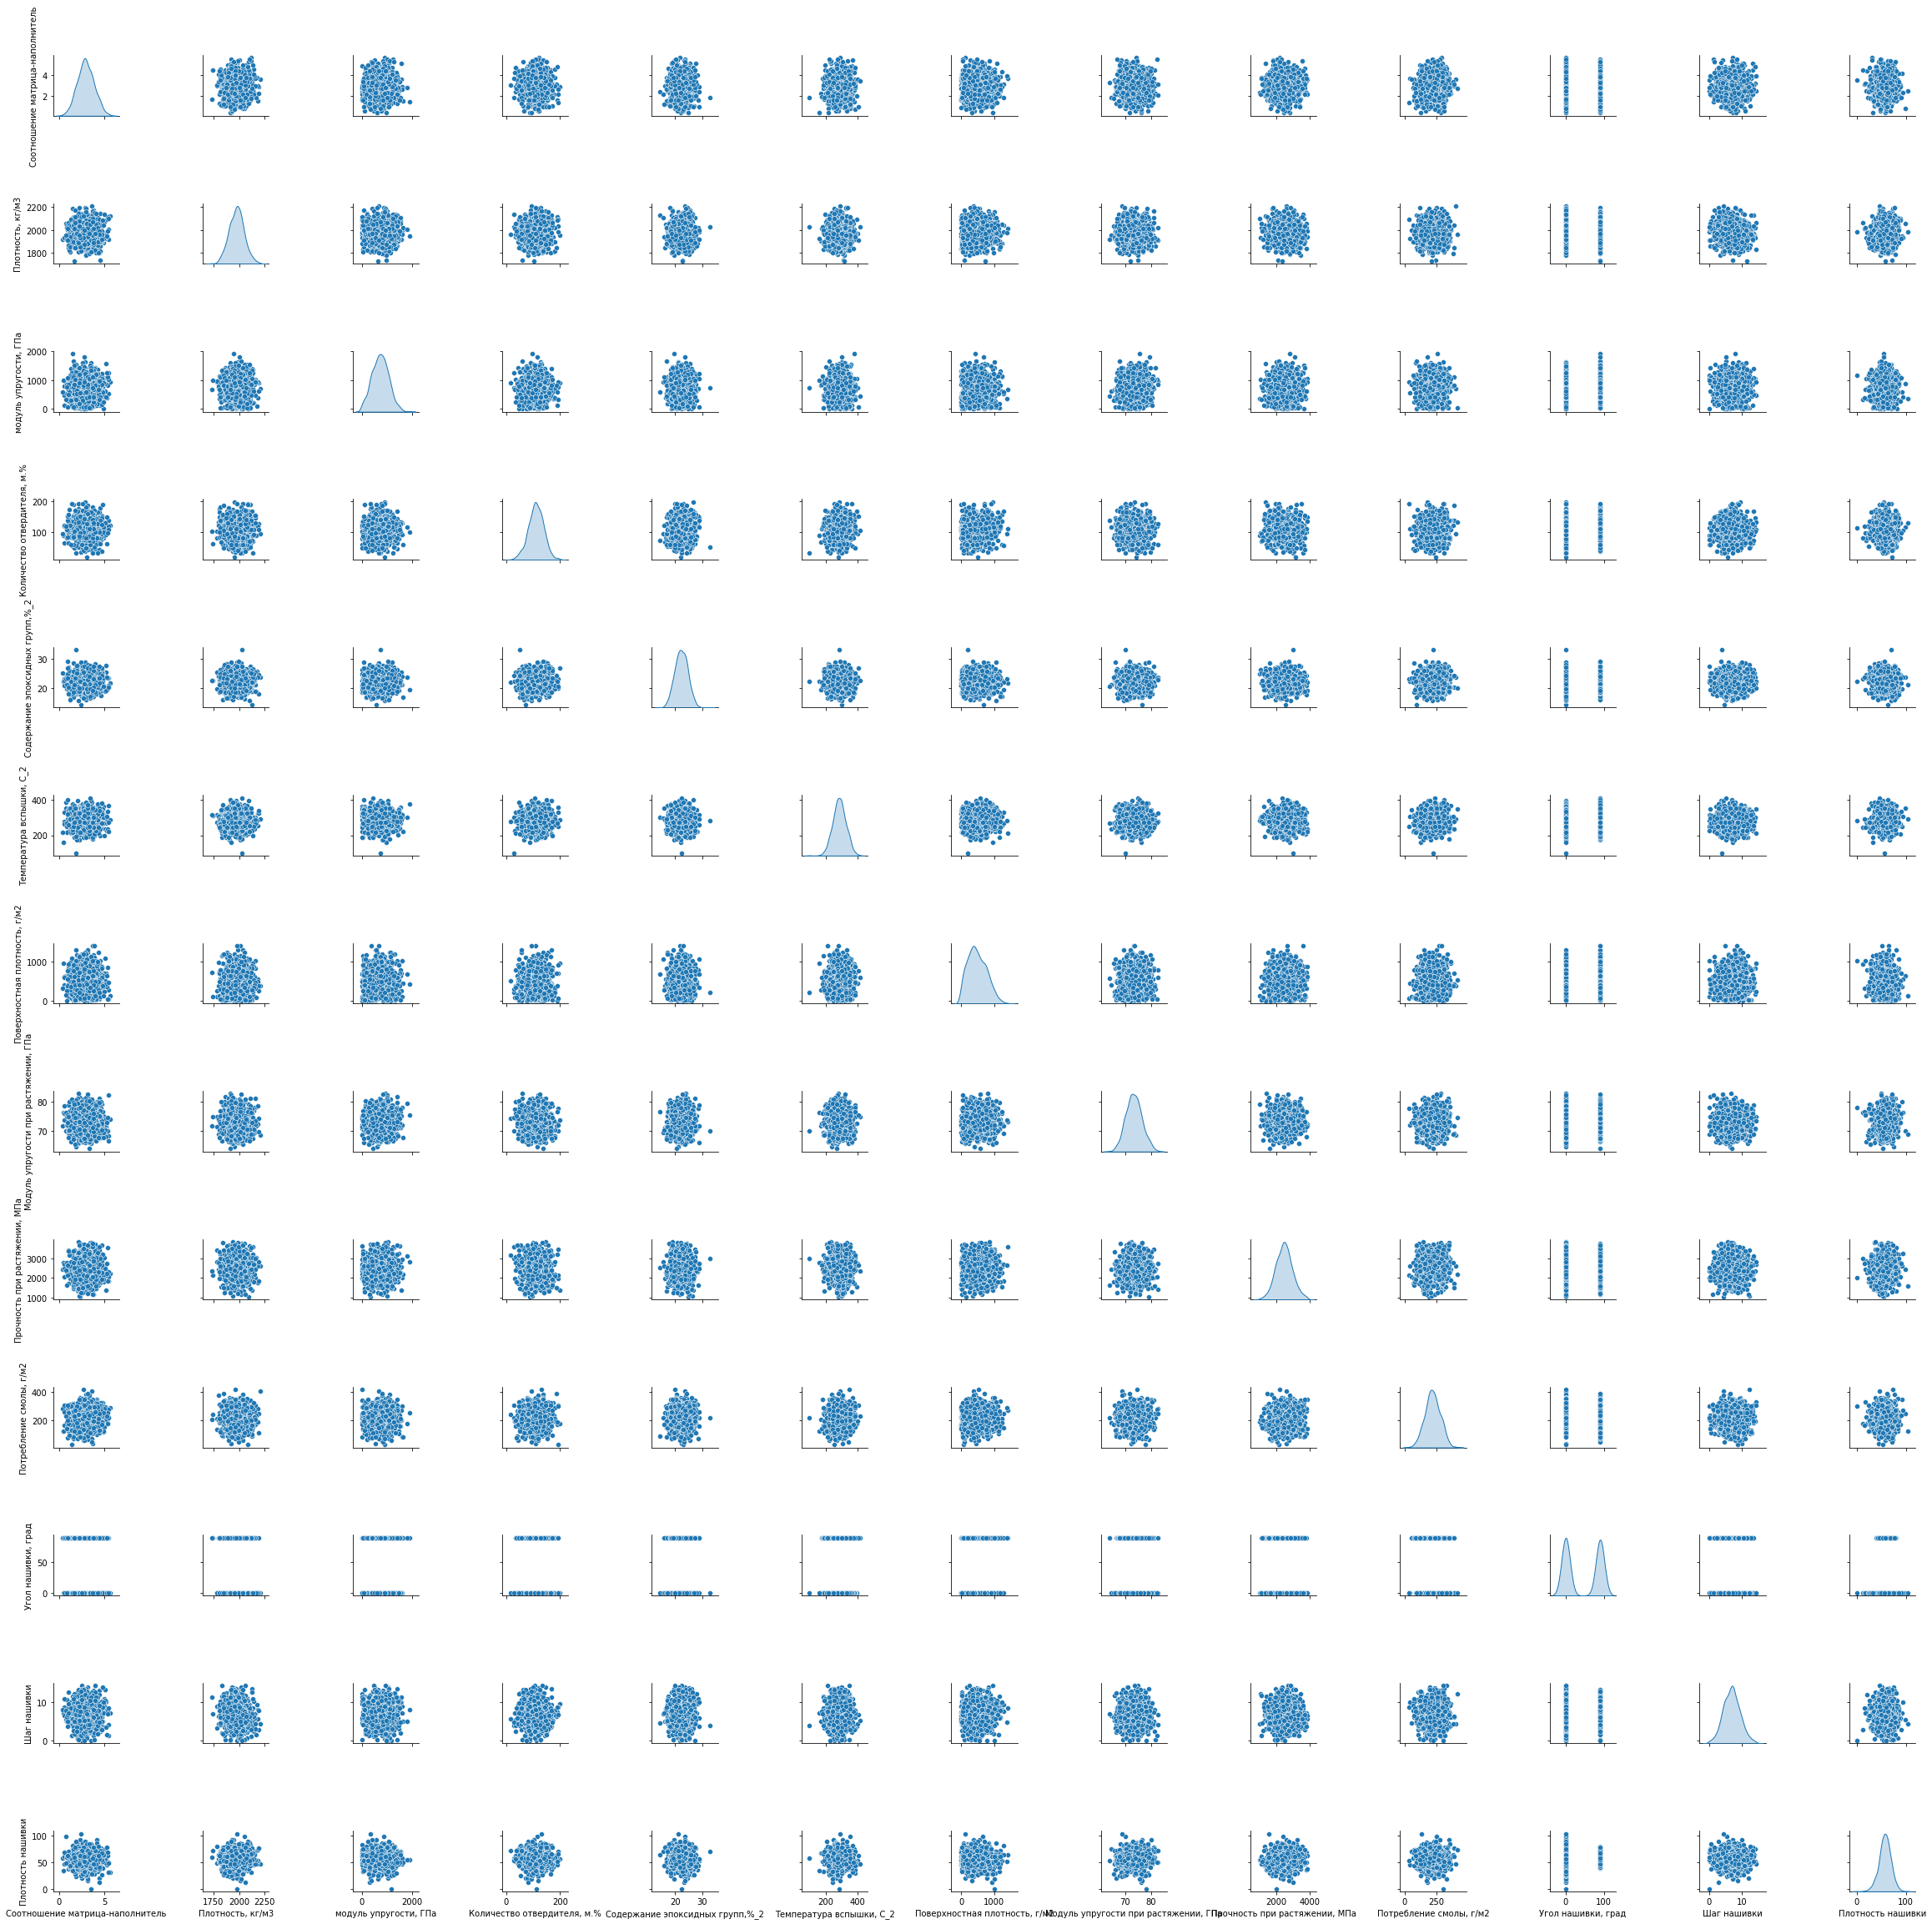

In [20]:
sns.pairplot(Df, diag_kind='kde')

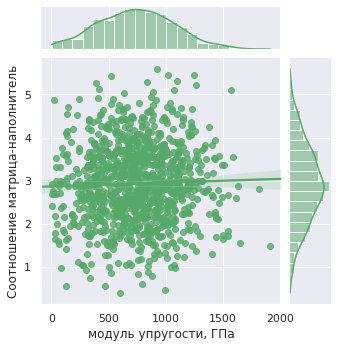

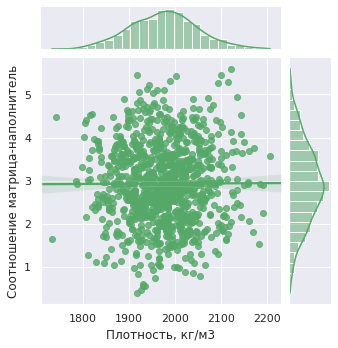

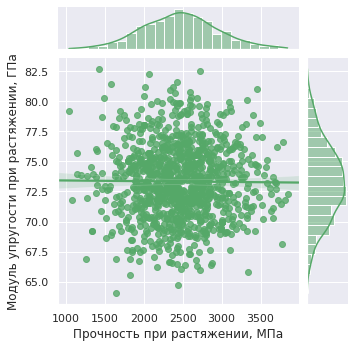

In [21]:
sns.set_theme(style="darkgrid")
sns.jointplot(x="модуль упругости, ГПа", y="Соотношение матрица-наполнитель", data=Df,
                  kind="reg", truncate=False, color="g", height=5)
sns.jointplot(x="Плотность, кг/м3", y="Соотношение матрица-наполнитель", data=Df,
                  kind="reg", truncate=False, color="g", height=5)
sns.jointplot(x="Прочность при растяжении, МПа", y="Модуль упругости при растяжении, ГПа", data=Df,
                  kind="reg", truncate=False, color="g", height=5)

Text(0.5, 1.0, 'Тепловая карта корреляции параметров')

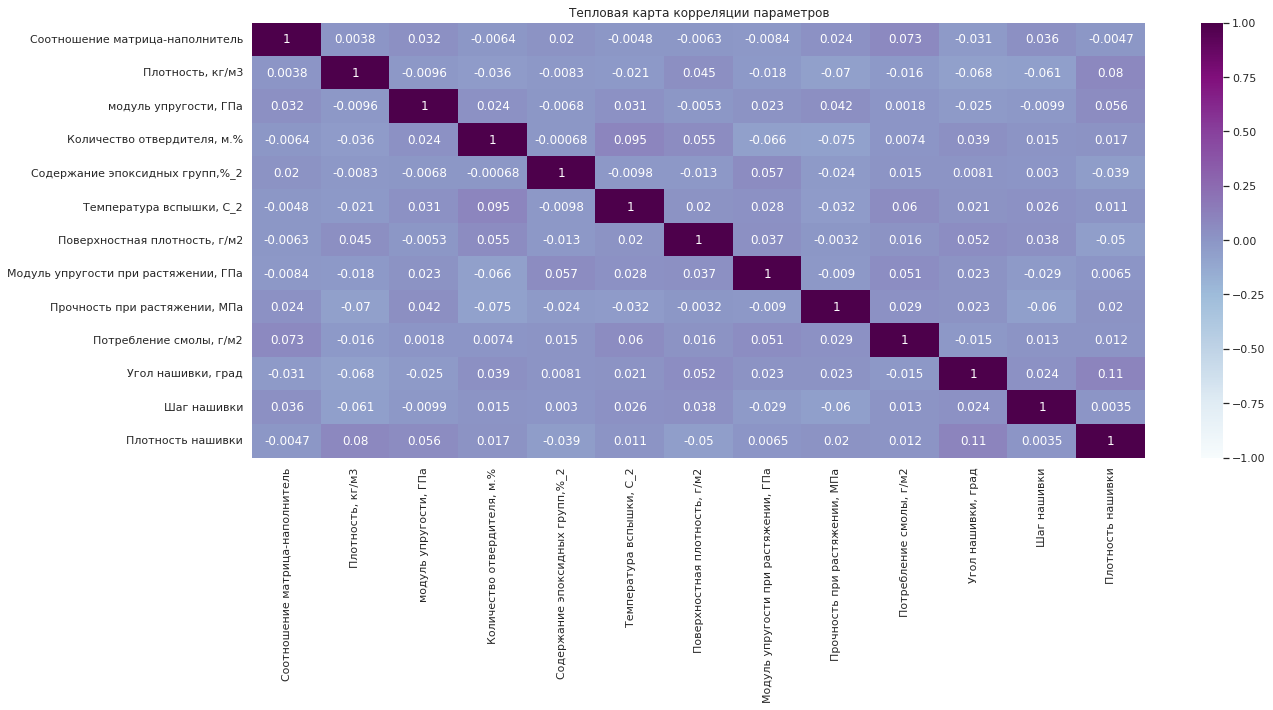

In [22]:
#Тепловая карта матрицы ковариоционной матрицы
plt.figure(figsize=(20, 8))
heatmap = sns.heatmap(Df.corr(), vmin=-1, vmax=1, annot=True, cmap='BuPu') 
heatmap.set_title('Тепловая карта корреляции параметров')

<function matplotlib.pyplot.show>

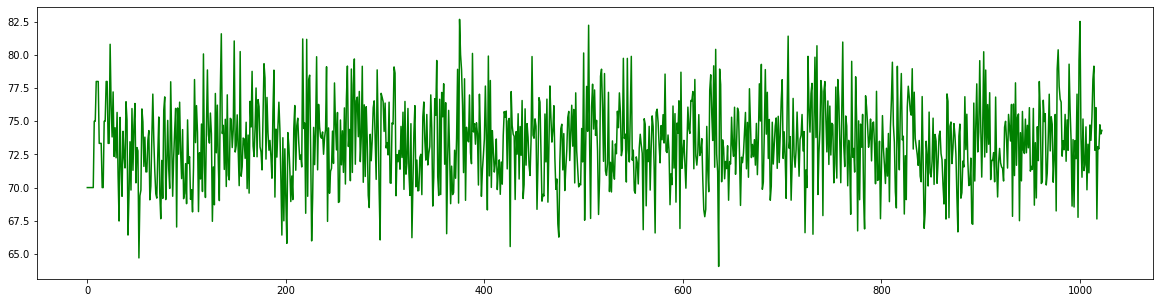

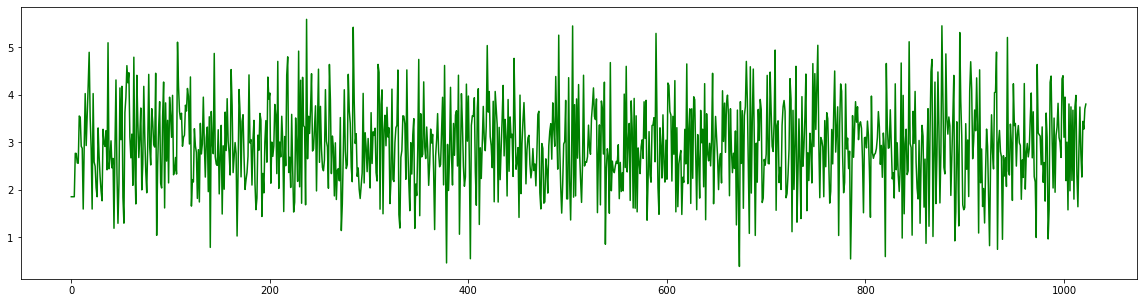

In [20]:
x = np.arange(0, 1023) 
plt.figure(figsize=(20, 5))
plt.plot(x, Df['Модуль упругости при растяжении, ГПа'], "g")
plt.show

x = np.arange(0, 1023) 
plt.figure(figsize=(20, 5))
plt.plot(x, Df['Соотношение матрица-наполнитель'], "g")
plt.show

По результатам анализа, пропуски в данных отсутсвуют, все параметры распределены по нормальному распределению, кроме Угла нашивки, который принимает всего два значения. В данных присуствуют выбросы. Параметры не имеют явной линейной корреляции. Все параметры кроме Угла нашивки имеют вещественный тип с очень высокой точностью. Например величина Модуль упругости, измеряемый в сотнях ГПа имеет точность 12 знаков после запятой? Что это - невероятная точность измерения или погрешность вычисления? такая точность, при условии отсуствия уникальлных значений вряд ли будет способствовать эффективному прогнозированию. Требуется проверить данные на наличие шумов. 

# Предобработка данных

#Устранение выбросов

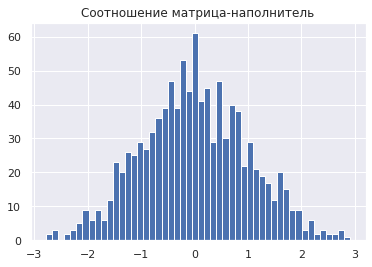

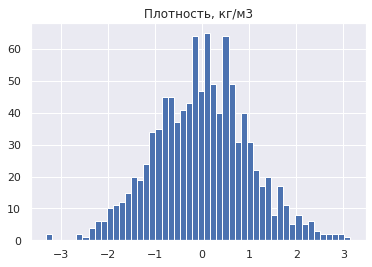

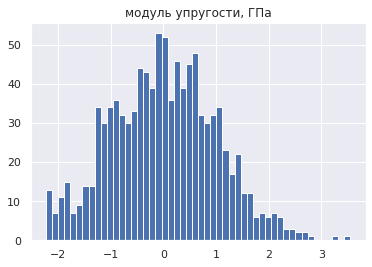

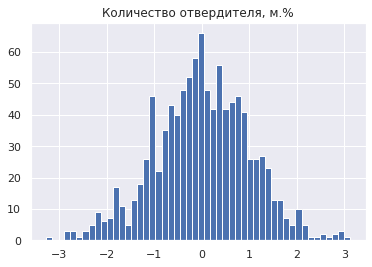

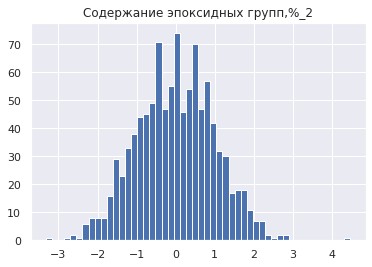

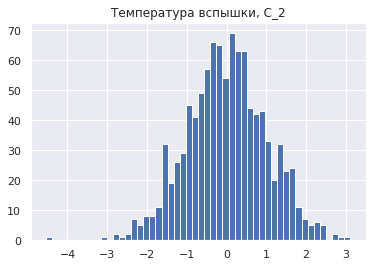

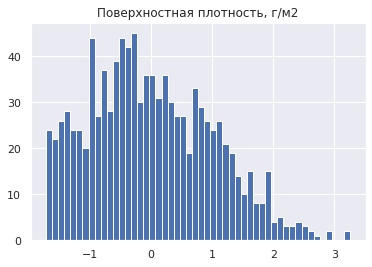

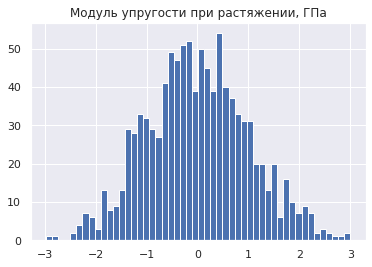

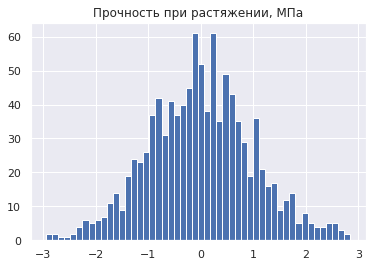

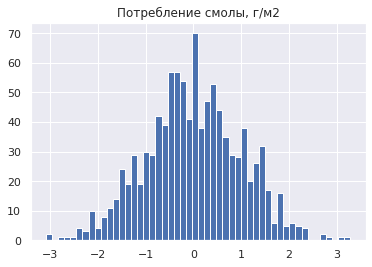

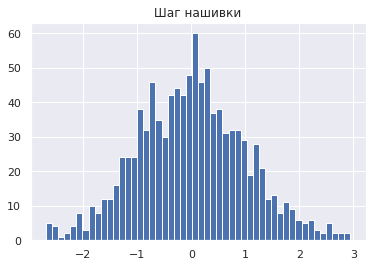

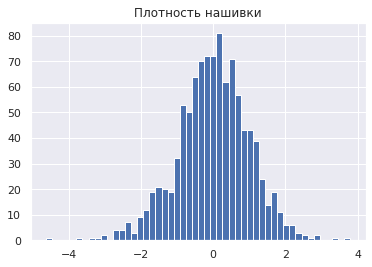

Всего выбросов = 26


In [23]:
#3 сигмы
i=1
Df_in = Df.copy()
for col in Df_in.columns.drop(['Угол нашивки, град']) :
  z_score =stats.zscore(Df_in[col], ddof=0, nan_policy='omit')
  Df_in[col+'z']=z_score
  for n in z_score :
    if abs(n)>3 :
      i+=1
  plt.title(col)
  plt.hist(z_score, 50)
  plt.show()
print('Всего выбросов = '+ str(i))


Методом 3-Сигмы нашли всего 25 выбросов во всем датасете. Проверим выбросы с помощью случайного леса

 1    903
-1    120
Name: iso_forest_outliers, dtype: int64


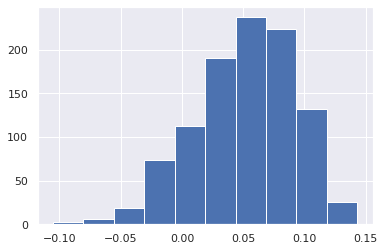

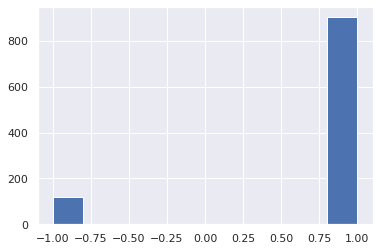

<class 'pandas.core.frame.DataFrame'>
1.0000    903
Name: iso_forest_outliers, dtype: int64
903


In [24]:
#случайный лес
from sklearn.ensemble import IsolationForest
isf = IsolationForest(n_estimators=15, random_state=42)
preds = isf.fit_predict(Df[['Соотношение матрица-наполнитель', 'Плотность, кг/м3', 'модуль упругости, ГПа', 'Количество отвердителя, м.%', 'Содержание эпоксидных групп,%_2', 'Температура вспышки, С_2', 'Поверхностная плотность, г/м2', 'Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа', 'Потребление смолы, г/м2', 'Шаг нашивки', 'Плотность нашивки']])
Df_d = Df.copy()
Df_d['iso_forest_outliers'] = preds
Df_d['iso_forest_scores'] = isf.decision_function(Df_d[['Соотношение матрица-наполнитель', 'Плотность, кг/м3', 'модуль упругости, ГПа', 'Количество отвердителя, м.%', 'Содержание эпоксидных групп,%_2', 'Температура вспышки, С_2', 'Поверхностная плотность, г/м2', 'Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа', 'Потребление смолы, г/м2', 'Шаг нашивки', 'Плотность нашивки']])

print(Df_d['iso_forest_outliers'].value_counts())

plt.hist(Df_d['iso_forest_scores'])
plt.show()
plt.hist(Df_d['iso_forest_outliers'])
plt.show()


Df_d.loc[Df_d['iso_forest_outliers'] == -1,'iso_forest_outliers'] = np.nan
print(type(Df_d))
print(Df_d['iso_forest_outliers'].value_counts())
Df_dd =Df_d.dropna(how='any').drop(['iso_forest_scores','iso_forest_outliers'], axis=1)

print(len(Df_dd))




# Нормализация данных/разбиение на x/y

In [25]:
#Нормализация признаков
minmax_sc = MinMaxScaler()
Df_norm = minmax_sc.fit_transform(np.array(Df_dd))
len(Df_norm[0])

13

In [26]:
#Н выходе получаем np.array, поэтому возвращаем обратно в датафрейм с названием колонок
Df_norm_DF = pd.DataFrame(data = Df_norm, columns = ['Соотношение матрица-наполнитель', 
                             'Плотность, кг/м3', 
                             'модуль упругости, ГПа', 
                             'Количество отвердителя, м.%', 
                             'Содержание эпоксидных групп,%_2', 
                             'Температура вспышки, С_2', 
                             'Поверхностная плотность, г/м2', 
                             'Модуль упругости при растяжении, ГПа', 
                             'Прочность при растяжении, МПа', 
                             'Потребление смолы, г/м2', 
                             'Угол нашивки, град', 
                             'Шаг нашивки', 
                             'Плотность нашивки'])
Df_norm_DF.head()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,0.2821,0.6476,0.3857,0.1861,0.4596,0.4635,0.1506,0.3192,0.6945,0.5223,0.0000,0.2751,0.6262
1,0.2821,0.6476,0.3857,0.1856,1.0000,0.4635,0.1506,0.3192,0.6945,0.5223,0.0000,0.2751,0.7560
2,0.2821,0.6476,0.3857,0.6420,0.3136,0.5276,0.1506,0.3192,0.6945,0.5223,0.0000,0.3445,0.4575
3,0.4579,0.6476,0.3932,0.5431,0.3731,0.4635,0.1506,0.3192,0.6945,0.5223,0.0000,0.3445,0.5873
4,0.4572,0.5824,0.3905,0.5431,0.3731,0.4635,0.1506,0.3192,0.6945,0.5223,0.0000,0.3445,0.6262


In [27]:
Df_norm_DF.describe().T

,count,mean,std,min,25%,50%,75%,max
Соотношение матрица-наполнитель,903.0000,0.4900,0.1717,0.0000,0.3742,0.4853,0.6076,1.0000
"Плотность, кг/м3",903.0000,0.5287,0.1552,0.0000,0.4208,0.5339,0.6280,1.0000
"модуль упругости, ГПа",903.0000,0.3941,0.1662,0.0000,0.2748,0.3919,0.5051,1.0000
"Количество отвердителя, м.%",903.0000,0.5384,0.1542,0.0000,0.4352,0.5391,0.6450,1.0000
"Содержание эпоксидных групп,%_2",903.0000,0.3726,0.1348,0.0000,0.2801,0.3723,0.4693,1.0000
"Температура вспышки, С_2",903.0000,0.4724,0.1632,0.0000,0.3665,0.4698,0.5797,1.0000
"Поверхностная плотность, г/м2",903.0000,0.3460,0.1947,0.0000,0.1953,0.3247,0.4902,1.0000
"Модуль упругости при растяжении, ГПа",903.0000,0.4971,0.1623,0.0000,0.3904,0.4947,0.6035,1.0000
"Прочность при растяжении, МПа",903.0000,0.5007,0.1648,0.0000,0.3886,0.4985,0.6052,1.0000
"Потребление смолы, г/м2",903.0000,0.5186,0.1647,0.0000,0.4091,0.5199,0.6292,1.0000


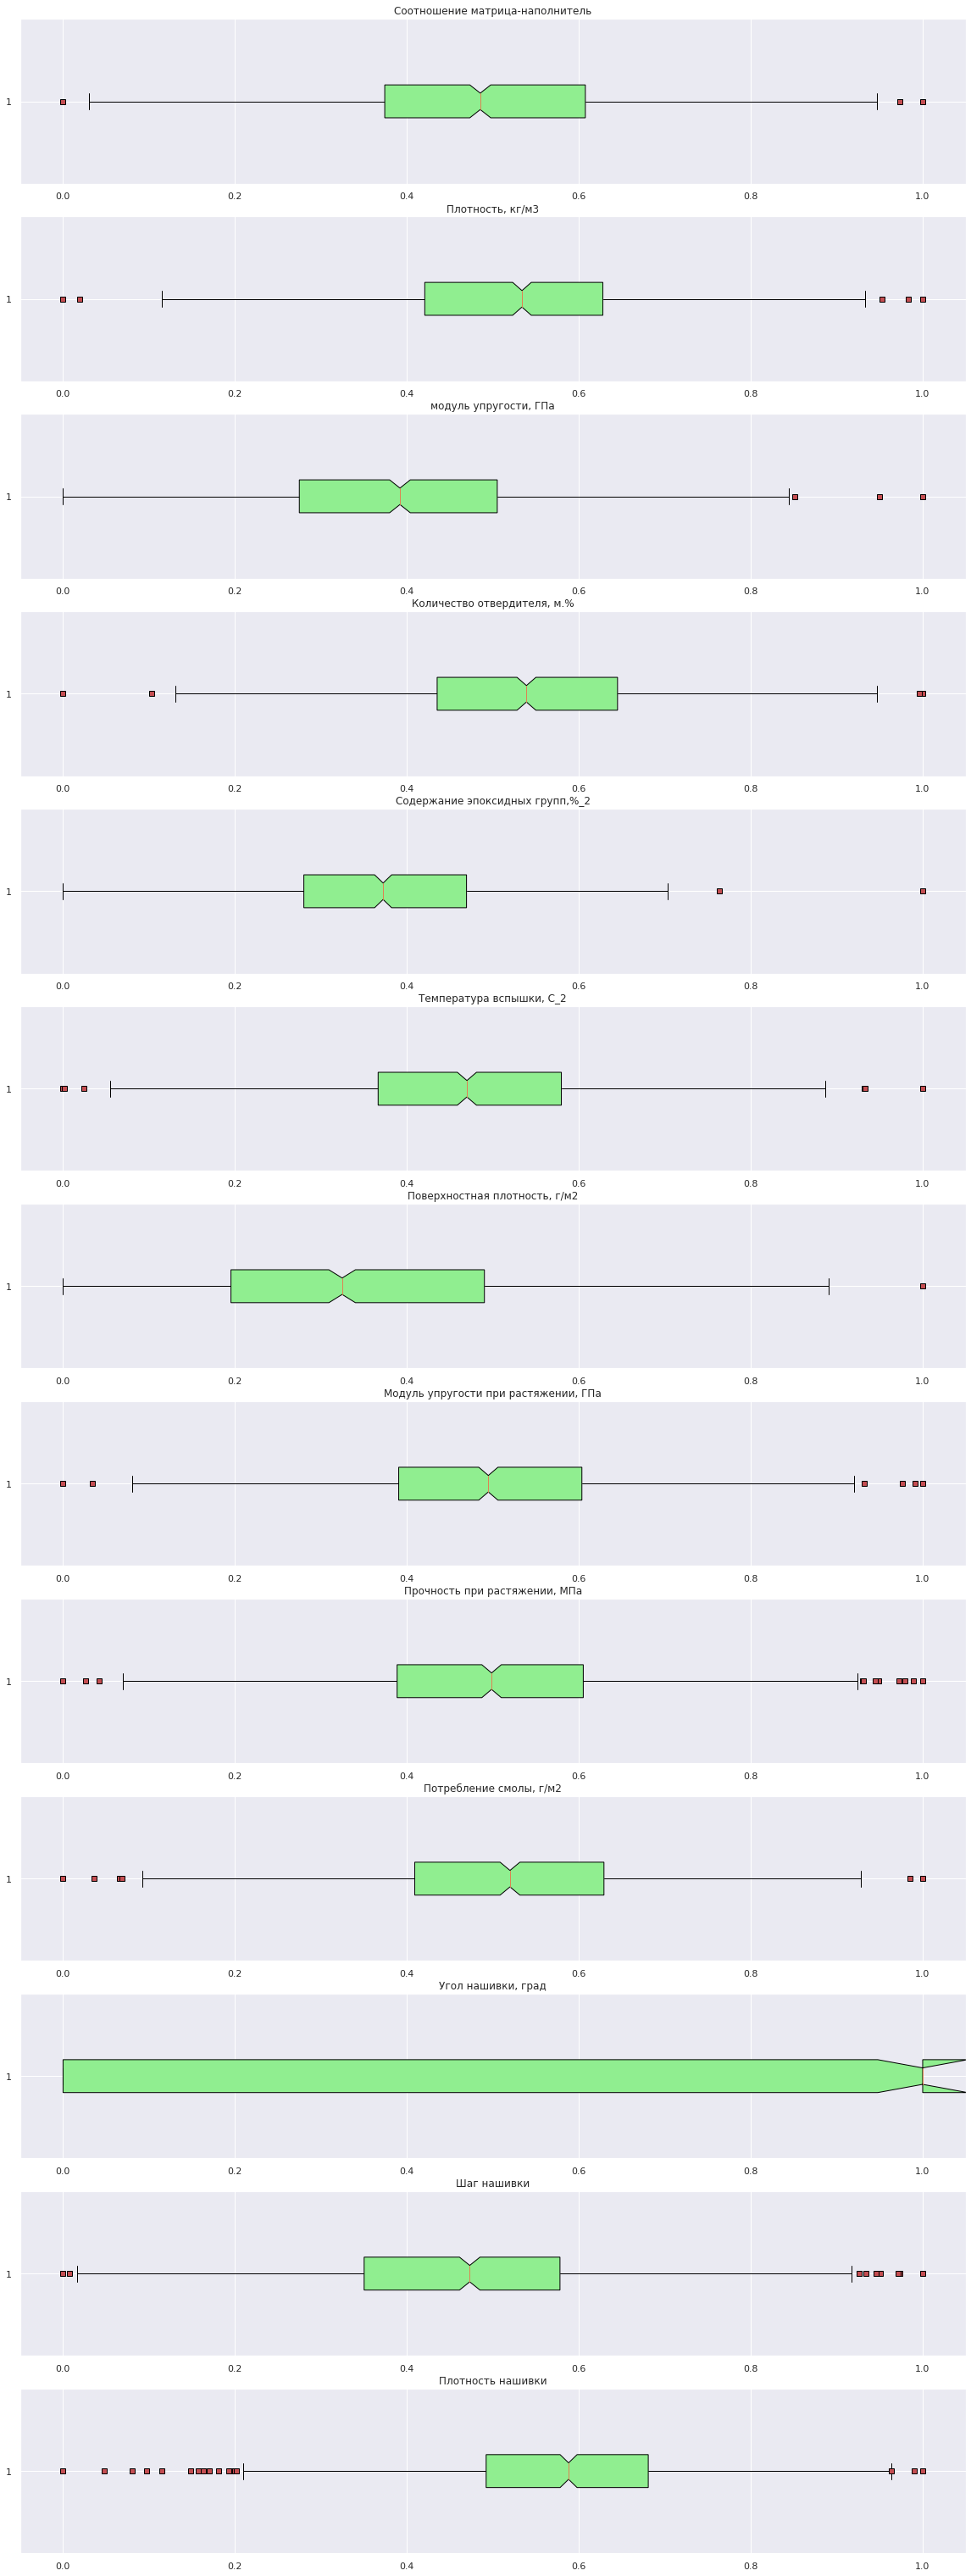

In [28]:
fig = plt.figure(figsize=(20,55))
axes = fig.subplots(nrows=13)
n = 0 
for p in Df_norm_DF.columns:
    axes[n].set(title=p)
    bp = axes[n].boxplot(Df_norm_DF[p], vert=False, flierprops=dict(markerfacecolor='r', marker='s'), widths=0.2, notch=True, patch_artist=True)
    for nB in bp['boxes']:
        nB.set_facecolor('lightgreen')
    n += 1
 
plt.show()

In [109]:
x_data = Df_norm_DF.drop(['Модуль упругости при растяжении, ГПа'], axis=1)
y_data = Df_norm_DF['Модуль упругости при растяжении, ГПа']
x_train_data, x_test_data, y_train_data, y_test_data = train_test_split(x_data, y_data, test_size=0.3, random_state=42)
print ('размерность обучающей выборки x = ', x_train_data.shape)
print ('размерность обучающей выборки y = ', y_train_data.shape)
print ('размерность тестовой выборки x = ', x_test_data.shape)
print ('размерность обучающей выборки y = ', y_test_data.shape)

размерность обучающей выборки x =  (632, 12)
размерность обучающей выборки y =  (632,)
размерность тестовой выборки x =  (271, 12)
размерность обучающей выборки y =  (271,)


# Обучение моделей

In [110]:
result_R2 = {}
result_MSE = {}
result_MAE = {}

In [182]:
#Линейная регрессия с кроссвалидацией
LR = LinearRegression()

results = cross_val_score(LR, x_train_data, y_train_data, cv=10, scoring='r2')
print(results)
LR.fit(x_train_data, y_train_data)
y_pred = LR.predict(x_test_data)
score_LR = LR.score(x_test_data, y_test_data)
MSE = mean_squared_error(y_test_data,y_pred)
MAE = mean_absolute_error(y_test_data,y_pred)
print('score R2= ' + str(score_LR))
print('MSE= ' + str(mean_squared_error(y_test_data,y_pred)))
print('MAE= ' + str(mean_absolute_error(y_test_data,y_pred)))


[-0.05220869 -0.012232   -0.00797464 -0.04434269  0.0048503  -0.02388451
 -0.05669805 -0.04536899 -0.03055905 -0.06837678]
score R2= -0.02337938859321631
MSE= 0.028086876779022496
MAE= 0.13976283155059643


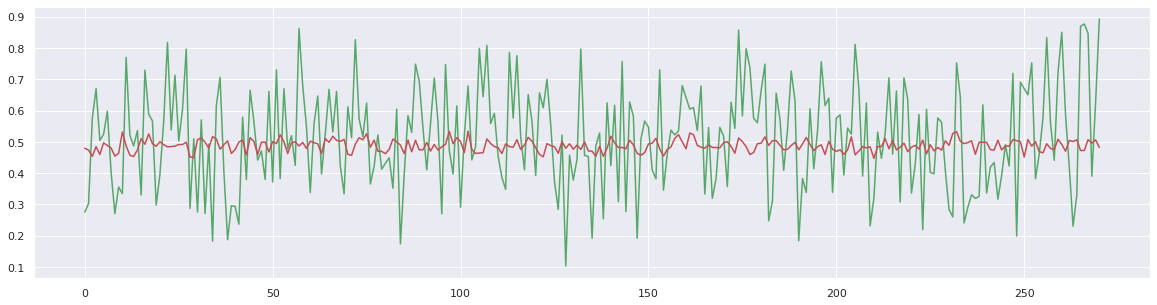

In [183]:
x = np.arange(0, len(y_pred)) 
plt.figure(figsize=(20, 5))
plt.plot(x, y_test_data, "g")
plt.plot(x, y_pred, "r")

In [127]:
result_R2['linear'] = score_LR
result_MSE['linear'] = MSE
result_MAE['linear'] = MAE

Функция поиска гиперпараметров по сетке с перекрестной проверкой, количество блоков равно 10

In [43]:

def GSCV_fit (model, grid, x_train_data, y_train_data) :
  GSCV = GridSearchCV(model, grid, cv=10, n_jobs=-1, verbose=0, return_train_score=True)
  params = GSCV.fit(x_train_data, y_train_data)
  return params 


In [117]:
#RandomForestRegressor
model = RandomForestRegressor()
grid = {'n_estimators': [10, 100, 800], 'bootstrap': [False, True], 'max_features': [0.15, 10, "log2"],'min_samples_leaf':[1,10,20], 'min_samples_split': [2,5]} 
GSCV_RF=GSCV_fit(model, grid, x_train_data, y_train_data) 

In [118]:
scores = GSCV_RF.cv_results_["mean_test_score"]
scores_std = GSCV_RF.cv_results_["std_test_score"]
best_parameters = GSCV_RF.best_params_
best_estimator = GSCV_RF.best_estimator_
print(best_estimator)
print(GSCV_RF.best_score_)

y_pred = best_estimator.predict(x_test_data)

score_RF = best_estimator.score(x_test_data, y_test_data)
MSE_RF = mean_squared_error(y_test_data, y_pred)
MAE_RF = mean_absolute_error(y_test_data,y_pred)

print('score R2= ' + str(scores_std))
print('MSE= ' + str(mean_squared_error(y_test_data,y_pred)))
print('MAE= ' + str(mean_absolute_error(y_test_data,y_pred)))

result_R2['RandomForestRegressor'] = score_RF
result_MSE['RandomForestRegressor'] = MSE_RF
result_MAE['RandomForestRegressor'] = MAE_RF

RandomForestRegressor(max_features=0.15, min_samples_leaf=20, n_estimators=10)
-0.021790268245719578
score R2= [0.09838584 0.05785201 0.04340189 0.06624715 0.0482847  0.03917
 0.04138474 0.01874933 0.02079521 0.03269967 0.02365617 0.0217342
 0.02423295 0.01294159 0.01683162 0.02597538 0.01954202 0.01897627
 0.21307904 0.14590392 0.1555039  0.1743669  0.14811431 0.15886903
 0.11381578 0.11184078 0.11504177 0.10949951 0.10946636 0.11238188
 0.09795385 0.08526608 0.08539032 0.10591426 0.08032435 0.08409863
 0.08359241 0.04838819 0.05668854 0.11155025 0.05592838 0.05901313
 0.04612993 0.02590125 0.03247484 0.03876105 0.03680352 0.03197337
 0.04655249 0.02363866 0.0210317  0.02768245 0.02315799 0.0223802
 0.10833654 0.04161122 0.03354108 0.03593524 0.04228311 0.03502389
 0.02014284 0.02098045 0.0165375  0.03835053 0.02999474 0.01770916
 0.02926336 0.02296069 0.01822746 0.02540066 0.024125   0.0168308
 0.15331958 0.04303742 0.03590811 0.10767946 0.0430344  0.03577457
 0.0519873  0.0245282  0

In [119]:
print(best_parameters)

{'bootstrap': True, 'max_features': 0.15, 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 10}


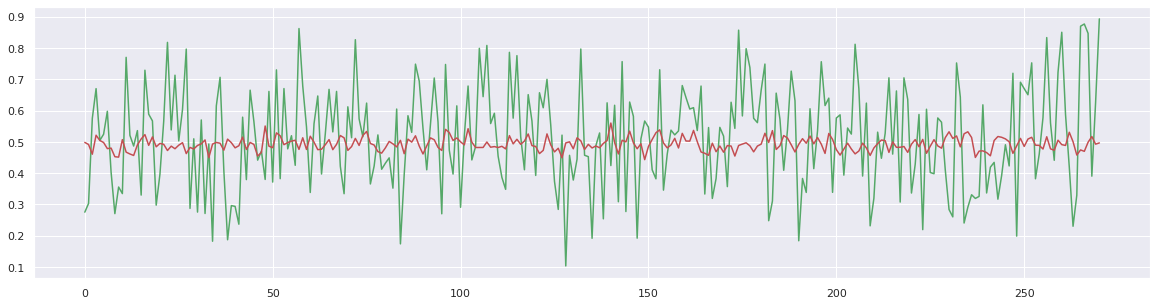

In [120]:
x = np.arange(0, len(y_pred)) 
plt.figure(figsize=(20, 5))
plt.plot(x, y_test_data, "g")
plt.plot(x, y_pred, "r")

In [131]:
#ridge_regression
model = RidgeCV(alphas = [0.001, 0.1, 1], cv = 10, gcv_mode='auto').fit(x_train_data, y_train_data)
score_RR = model.score(x_train_data,y_train_data)
y_pred= model.predict(x_test_data)
MSE_RR = mean_squared_error(y_test_data,y_pred)
MAE_RR = mean_absolute_error (y_test_data,y_pred)
print('score R2= ' + str(score))
print('MSE= ' + str(MSE_RR))
print('MAE= ' + str(MAE_RR))

result_R2['Ridge_regression'] = score_RR
result_MSE['Ridge_regression'] = MSE_RR
result_MAE['Ridge_regression'] = MAE_RR

score R2= -0.0217530038466639
MSE= 0.02806899223820489
MAE= 0.13977598696938653


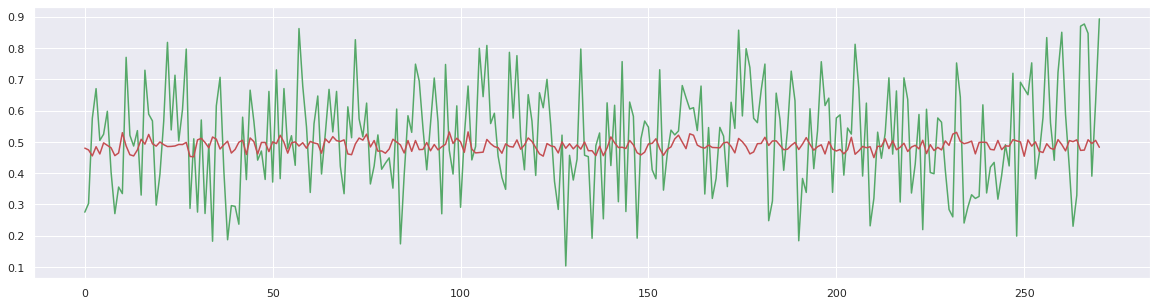

In [132]:
x = np.arange(0, len(y_pred)) 
plt.figure(figsize=(20, 5))
plt.plot(x, y_test_data, "g")
plt.plot(x, y_pred, "r")

In [133]:
#BaggingRegressor
model=BaggingRegressor()
grid = {'n_estimators': [10, 50, 100], 'random_state': [5, 42, 80], 'max_features': [1, 5, 10]}
GSCV_BR=GSCV_fit(model, grid, x_train_data, y_train_data)     

In [134]:
scores = GSCV_BR.cv_results_["mean_test_score"]
scores_std = GSCV_BR.cv_results_["std_test_score"]
best_parameters = GSCV_BR.best_params_
best_estimator = GSCV_BR.best_estimator_
print(best_estimator)
print(GSCV_BR.best_score_)

y_pred = best_estimator.predict(x_test_data)

score_BR = LR.score(x_test_data, y_test_data)
MSE_BR = mean_squared_error(y_test_data, y_pred)
MAE_BR = mean_absolute_error(y_test_data,y_pred)

result_R2['BaggingRegressor'] = score_BR
result_MSE['BaggingRegressor'] = MSE_BR
result_MAE['BaggingRegressor'] = MAE_BR

print('score R2= ' + str(score))
print('MSE_BR= ' + str(mean_squared_error(y_test_data,y_pred)))
print('MAE_BR= ' + str(mean_absolute_error(y_test_data,y_pred)))

BaggingRegressor(max_features=1, n_estimators=100, random_state=5)
-0.02261685490731722
score R2= -0.0217530038466639
MSE_BR= 0.027735202312479005
MAE_BR= 0.13736473773675692


Сравним результаты работы моделей по  метрикам

-0.02337938859321631
-0.025768949793677054
0.014172137617115443
-0.02337938859321631


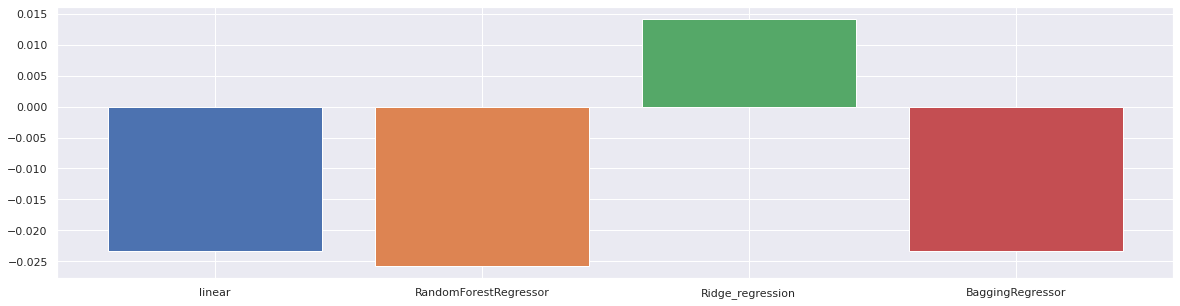

In [135]:
plt.figure(figsize=(20, 5))
for k in result_R2 :
  print(result_R2[k])
  plt.bar(str(k), result_R2[k])
plt.show()

0.13976283155059643
0.14062959239136083
0.13977598696938653
0.13736473773675692


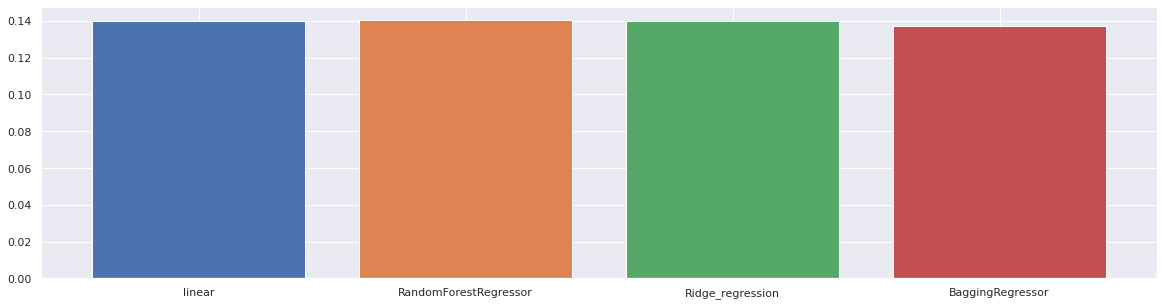

In [136]:
plt.figure(figsize=(20, 5))
for k in result_MSE :
  print(result_MAE[k])
  plt.bar(str(k), result_MAE[k])

plt.show()

Посмотрим резкльтат предсказания последней модели

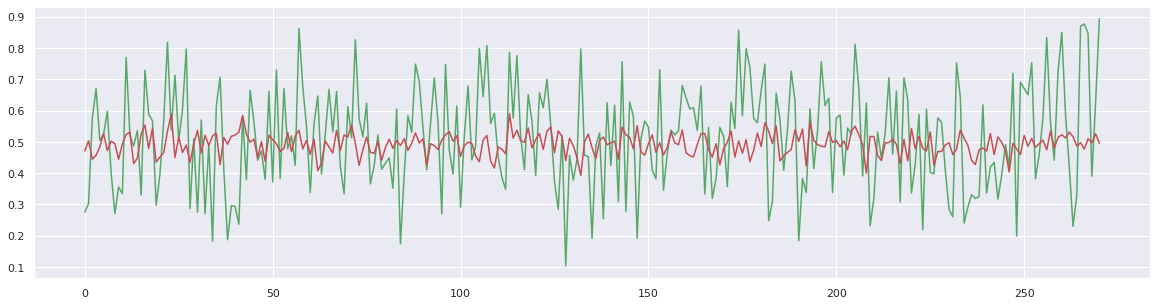

In [137]:
x = np.arange(0, len(y_pred)) 
plt.figure(figsize=(20, 5))
plt.plot(x, y_test_data, "g")
plt.plot(x, y_pred, "r")

Модели предсказывает значение, близкое к среднему

# Нейронная сеть

In [156]:
#В качестве исходных данных возьмем ненормализованный датафрейм, очищенный от выбросов 
x_data_n = Df_norm_DF.drop(['Соотношение матрица-наполнитель', 'Угол нашивки, град', ], axis=1)
y_data_n = Df_norm_DF[['Соотношение матрица-наполнитель']]
x_train_n, x_test_n, y_train_n, y_test_n = train_test_split(x_data_n, y_data_n, test_size=0.3, random_state=42)
print ('размерность обучающей выборки x = ', x_train_n.shape)
print ('размерность обучающей выборки y = ', y_train_n.shape)
print ('размерность тестовой выборки x = ', x_test_n.shape)
print ('размерность обучающей выборки y = ', y_test_n.shape)

размерность обучающей выборки x =  (632, 11)
размерность обучающей выборки y =  (632, 1)
размерность тестовой выборки x =  (271, 11)
размерность обучающей выборки y =  (271, 1)


In [157]:
y_train_n.head()

,Соотношение матрица-наполнитель
467,0.4762
449,0.4224
439,0.9733
398,0.4809
299,0.3739


In [173]:


model = tf.keras.models.Sequential()
model.add(Dense(11, activation ='relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation ='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation ='relu'))

model.compile(loss = 'mse', optimizer = 'adam', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)
result = model.fit(x_train_n,
                    y_train_n,
                    batch_size = 64,
                    epochs = 100,
                    validation_data = (x_test_n, y_test_n),
                    verbose = 1,
                    callbacks=early_stop)

Epoch 1/100
10/10 [==============================] - 1s 20ms/step - loss: 0.1392 - mae: 0.3181 - val_loss: 0.0812 - val_mae: 0.2395
Epoch 2/100
10/10 [==============================] - 0s 8ms/step - loss: 0.1089 - mae: 0.2624 - val_loss: 0.0485 - val_mae: 0.1833
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0989 - mae: 0.2519 - val_loss: 0.0407 - val_mae: 0.1678
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0889 - mae: 0.2391 - val_loss: 0.0404 - val_mae: 0.1670
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0937 - mae: 0.2468 - val_loss: 0.0417 - val_mae: 0.1696
Epoch 6/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0850 - mae: 0.2332 - val_loss: 0.0429 - val_mae: 0.1718
Epoch 7/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0794 - mae: 0.2253 - val_loss: 0.0430 - val_mae: 0.1719
Epoch 7: early stopping


In [174]:
y_predict_NN = model.predict(x_test_n)
y_predict_NN[0]

array([0.51892], dtype=float32)

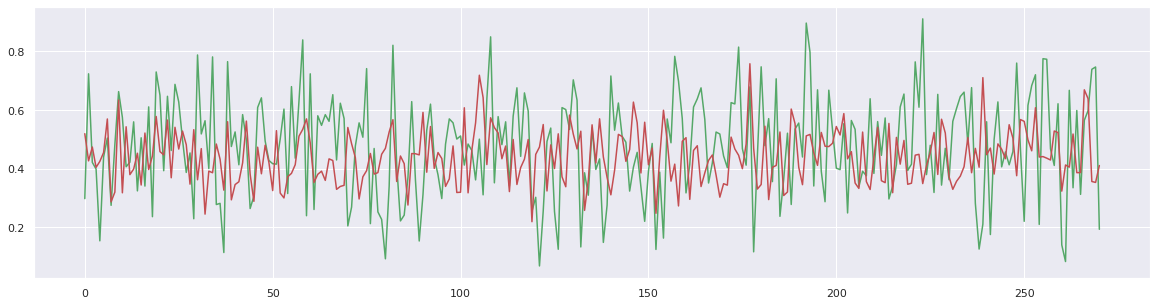

In [175]:
x = np.arange(0, len(y_predict_NN)) 
plt.figure(figsize=(20, 5))
plt.plot(x, y_test_n, "g")
plt.plot(x, y_predict_NN, "r")

In [176]:
R2_NU_1 = r2_score(y_test_n,y_predict_NN)
R2_NU_1

-0.33860353914454744

In [177]:
df_results_nn = pd.DataFrame(result.history)
df_results_nn['epoch'] = result.epoch
df_results_nn

,loss,mae,val_loss,val_mae,epoch
0,0.1392,0.3181,0.0812,0.2395,0
1,0.1089,0.2624,0.0485,0.1833,1
2,0.0989,0.2519,0.0407,0.1678,2
3,0.0889,0.2391,0.0404,0.1670,3
4,0.0937,0.2468,0.0417,0.1696,4
5,0.0850,0.2332,0.0429,0.1718,5
6,0.0794,0.2253,0.0430,0.1719,6


Text(0.5, 0, 'Epoch')

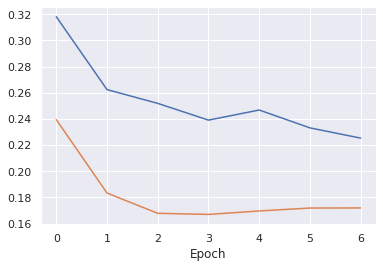

In [178]:
plt.plot(df_results_nn['mae'], label='mae')
plt.plot(df_results_nn['val_mae'], label='val_mae')
plt.xlabel('Epoch')


# Сохранение модели


Text(0.5, 0, 'n')

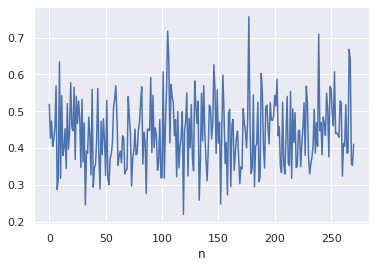

In [180]:

plt.plot(y_predict_NN, label='predict')

plt.xlabel('n')

In [181]:
with open('nn_model.pkl', 'wb') as fl:
  pickle.dump(model, fl)

INFO:tensorflow:Assets written to: ram://da1faba4-4497-4dd9-9b61-b5e4c3edf3ee/assets
